In [318]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import nbformat
from pypfopt import EfficientFrontier, risk_models, expected_returns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error



%store -r result_df 

pd.set_option('display.width', 200)  # Set a large width
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Prevent line wrapping


print(result_df)

       symbol           timestamp       open        high           low       close       volume  trade_count          vwap  signal  supertrend
0     BTC/USD 2021-01-01 06:00:00  29255.710  29682.2900  28707.560000  29676.7900   848.874030      29639.0  29316.444625       0         NaN
1     BTC/USD 2021-01-02 06:00:00  29678.340  34200.0000  29555.990000  33769.5200  2144.592516      60152.0  31941.412694       0         0.0
2     BTC/USD 2021-01-03 06:00:00  33769.520  34812.9300  32300.610000  32908.0200  1838.695433      58725.0  33505.269474       0         0.0
3     BTC/USD 2021-01-04 06:00:00  32907.360  33496.0300  27900.000000  30441.5700  2711.189503      69226.0  31267.965121       0         0.0
4     BTC/USD 2021-01-05 06:00:00  30461.840  35851.4200  29927.550000  35063.0000  1756.751333      61880.0  33151.367357       0         0.0
...       ...                 ...        ...         ...           ...         ...          ...          ...           ...     ...         ...

In [319]:
print(result_df.describe())

print(result_df.isna().sum())

print(result_df.dtypes)

                           timestamp           open           high            low          close         volume    trade_count           vwap       signal   supertrend
count                           3074    3074.000000    3074.000000    3074.000000    3074.000000    3074.000000    3074.000000    3074.000000  3074.000000  3072.000000
mean   2023-02-08 05:22:31.463890688   23790.896386   24370.805472   23146.163718   23808.263887    9147.158769   39402.684450   23793.423311     0.003904    -0.014323
min              2021-01-01 06:00:00     735.290000     745.000000     716.650000     733.650000       0.042559       4.000000     731.807780    -1.000000    -1.000000
25%              2022-01-20 06:00:00    2285.510750    2366.112500    2194.150000    2286.269000       8.259423     129.000000    2288.598051    -1.000000    -1.000000
50%              2023-02-08 06:00:00   10304.985000   10562.785000    6453.570000   10304.475000    1082.850192   26223.500000   10337.574865     0.000000     0

# Feature Engineering
### 3 main inputs needed for the models are
### - VWAP-Supertrend signal strength, 
### - Risk Metrics 
### - Asset Correlations

#### VWAP-Supertrend Signal Strength

In [320]:
# Data preprocessing
result_df['timestamp'] = pd.to_datetime(result_df['timestamp'])
result_df = result_df.set_index(['timestamp', 'symbol']).unstack()

#Extract close Prices for returns calculation
close_prices = result_df['close']
close_prices.head()

symbol,BTC/USD,ETH/USD
timestamp,,
2021-01-01 06:00:00,29676.79,733.65
2021-01-02 06:00:00,33769.52,786.88
2021-01-03 06:00:00,32908.02,1086.86
2021-01-04 06:00:00,30441.57,991.40
2021-01-05 06:00:00,35063.00,1105.56


In [321]:
# VWAP-Supertrend Signal Strength
signal = result_df['signal']

#### Risk Metrics 

In [322]:
# Calulate daily returns
returns = close_prices.pct_change().dropna()

# Volatility (e.g 30-day rolling standard deviation)
volatility = returns.rolling(window=30).std()

#Drawdown
rolling_max = close_prices.cummax()
drawdown = (close_prices - rolling_max) / rolling_max
max_drawdown = drawdown.rolling(window=30, min_periods=1).min()

returns.head()

symbol,BTC/USD,ETH/USD
timestamp,,
2021-01-02 06:00:00,0.137910,0.072555
2021-01-03 06:00:00,-0.025511,0.381227
2021-01-04 06:00:00,-0.074950,-0.087831
2021-01-05 06:00:00,0.151813,0.115150
2021-01-06 06:00:00,0.069083,0.097082


#### Correlation Between Assets
Compute the correlation matrix of returns to understand how BTC/USD and ETH/USD move together.



In [323]:
correlation = returns.corr()
correlation

symbol,BTC/USD,ETH/USD
symbol,,
BTC/USD,1.000000,0.807342
ETH/USD,0.807342,1.000000


In [324]:
result_df.head()

open               high                low             close                volume              trade_count                   vwap               signal         supertrend        
symbol                BTC/USD  ETH/USD   BTC/USD  ETH/USD   BTC/USD ETH/USD   BTC/USD  ETH/USD      BTC/USD      ETH/USD     BTC/USD  ETH/USD       BTC/USD      ETH/USD BTC/USD ETH/USD    BTC/USD ETH/USD
timestamp                                                                                                                                                                                                  
2021-01-01 06:00:00  29255.71   742.15  29682.29   745.00  28707.56  716.65  29676.79   733.65   848.874030   6534.81013     29639.0   6514.0  29316.444625   731.807780       0       0        NaN     NaN
2021-01-02 06:00:00  29678.34   735.29  34200.00   791.08  29555.99  725.44  33769.52   786.88  2144.592516  16071.74933     60152.0  15214.0  31941.412694   769.787732       0       0        0.0     0.0
2021-01-03 06:00:00  33769.52   786.64  34812.93  1098.00  32300.61  784.55  32908.02  1086.86  1838.695433  44039.92386     58725.0  43031.0  33505.269474   942.620484       0       0        0.0     0.0
2021-01-04 06:00:00  32907.36  1086.86  33496.03  1169.05  27900.00  880.00  30441.57   991.40  2711.189503  50778.44556     69226.0  51353.0  31267.965121  1030.893782       0       0        0.0     0.0
2021-01-05 06:00:00  30461.84   992.00  35851.42  1138.00  29927.55  980.08  35063.00  1105.56  1756.751333  25283.79028     61880.0  26369.0  33151.367357  1073.661942       0       0        0.0     0.0

# Prepare the Dataset for the Model

Combining the features into a single dataframe aligned by timestamp

In [325]:
# combine features
features_df = pd.concat([
    signal.rename(columns={'BTC/USD': 'signal_btc', 'ETH/USD': 'signal_eth'}),
    volatility.rename(columns={'BTC/USD': 'vol_btc', 'ETH/USD': 'vol_eth'}),
    max_drawdown.rename(columns={'BTC/USD': 'drawdown_btc', 'ETH/USD': 'drawdown_eth'})
], axis=1).dropna()

# Add correlation as a feature (single value per timestamp)
features_df['corr_btc_eth'] = returns['BTC/USD'].rolling(window=30).corr(returns['ETH/USD'])
features_df.head()

symbol,signal_btc,signal_eth,vol_btc,vol_eth,drawdown_btc,drawdown_eth,corr_btc_eth
timestamp,,,,,,,
2021-01-31 06:00:00,0,0,0.062748,0.097499,-0.221947,-0.215613,0.513730
2021-02-01 06:00:00,0,0,0.057614,0.097210,-0.221947,-0.215613,0.521324
2021-02-02 06:00:00,0,0,0.058818,0.072247,-0.221947,-0.215613,0.825204
2021-02-03 06:00:00,1,1,0.056998,0.070358,-0.221947,-0.215613,0.812366
2021-02-04 06:00:00,0,1,0.050286,0.068249,-0.221947,-0.215613,0.812747


# Defining the Target (Portfolio Weights)

The goal is to allocate capital (weights) across assets. 

Using pyportfolioopt to generate target weights

In [326]:
# Initialize a DataFrame to store target weights (same index as close_prices)
target_weights = pd.DataFrame(index=close_prices.index, columns=close_prices.columns)

#Parameters
lookback = 365 # lookback window (365 trading days for 1 year)
# Loop through each timestamp (skip the first `lookback` days)
for i in range(lookback, len(close_prices)):
    historical_data = close_prices.iloc[i - lookback : i]

    # Calculate expected returns and covariance matrix
    mu = expected_returns.mean_historical_return(historical_data)
    S = risk_models.sample_cov(historical_data)

    # Optimize for maximum Sharpe ratio
    ef = EfficientFrontier(mu, S)
    try:
        ef.max_sharpe()
        weights = ef.clean_weights()
    except:
        #Handle optimization failures (e.g, singular matrix)
        weights = {asset: 0 for asset in historical_data.columns}

    # Store weights with the current timestamp
    target_weights.iloc[i] = weights

# Drop rows with NaN (first 'lookback' days)
target_weights = target_weights.dropna()
    

"""This approach ensures your model learns to predict weights that 
are grounded in realistic, time-dependent portfolio optimization."""


target_weights.head()


symbol,BTC/USD,ETH/USD
timestamp,,
2022-01-01 06:00:00,0.0,1.0
2022-01-02 06:00:00,0.0,1.0
2022-01-03 06:00:00,0.0,1.0
2022-01-04 06:00:00,0.0,1.0
2022-01-05 06:00:00,0.0,1.0


# Train the Machine Learning Model

Using Random Forest and Gradient Boosting to predict weights based on features

### Align Features (X) and Target (y)

Ensuring that features_df and target_weights share the same timestamp

In [327]:
# Prepare X (features) and y (target weights)
X = features_df
y = target_weights



common_index = X.index.intersection(y.index)
X = features_df.loc[common_index]
y = target_weights.loc[common_index]

# Proceed with train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



### Train Random Forest

In [328]:

# Train Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print(f"Train R^2: {train_score:.4f}, Test R^2: {test_score:.4f}")



Train R^2: 0.9945, Test R^2: 0.9722


### Train GradientBoosting using MultiOutputRegressor

In [329]:
# Train GradientBoosting 
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
multi_model = MultiOutputRegressor(gb)
multi_model.fit(X_train, y_train)  

# Evaluate
train_score_m = multi_model.score(X_train, y_train)
test_score_m = multi_model.score(X_test, y_test)
print(f"Train R^2: {train_score_m:.4f}, Test R^2: {test_score_m:.4f}")


Train R^2: 0.9854, Test R^2: 0.9503


# Predict and Allocate capital
Using the trained model to predict portfolio weights for new data
Would be using RandomForest Trained Model for our prediction

In [ ]:
# Predict weights for the latest data using randomforest
latest_features = features_df.tail(1)
predicted_weights = model.predict(latest_features)
weights_dict = dict(zip(close_prices.columns, predicted_weights[0]))
print("predicted_weights:", weights_dict)

predicted_weights: {'BTC/USD': 1.0, 'ETH/USD': 0.0}


In [331]:
# Predict weights for the latest data
latest_features_n = features_df.tail(1)
predicted_weights_n = multi_model.predict(latest_features_n)
weights_dict_n = dict(zip(close_prices.columns, predicted_weights_n[0]))
print("predicted_weights_n:", weights_dict_n)

predicted_weights_n: {'BTC/USD': 1.0047752325481496, 'ETH/USD': 0.0032864707073073486}


# Feature Importance (Gradient Boosting Specific)

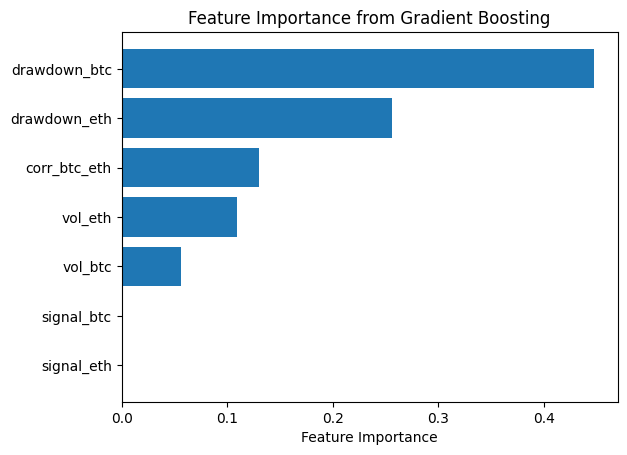

In [332]:


feature_importance = np.mean([est.feature_importances_ for est in multi_model.estimators_], axis=0)

sorted_idx = np.argsort(feature_importance)
plt.barh(X_train.columns[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Feature Importance from Gradient Boosting")
plt.show()

#